# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech)

Another common term for NLP problems is sequence to sequence problems (seq2seq).

## Check for GPU

In [2]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-4f799b0d-f5ab-5de1-f800-3105a6fd9273)


## Get helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-10-29 16:13:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-29 16:13:45 (66.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).


See the original source here: https://www.kaggle.com/c/nlp-getting-started

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2021-10-29 16:13:47--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.128, 108.177.120.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2021-10-29 16:13:47 (87.9 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to do so would be to use Python: https://realpython.com/read-write-files-python/

But I prefer to get visual straight away.

So another way to do this is to use pandas...

In [5]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [9]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index + 5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
NASA MODIS image: Dust storm over Morocco and the Straits of Gibraltar http://t.co/QWQnni7VMZ #duststorm

---

Target: 1 (real disaster)
Text:
Typhoon Soudelor approaches after 7 killed 2 missing in floods in Philippines http://t.co/nJMiDySXoF via @abc7chicago

---

Target: 1 (real disaster)
Text:
Lol
Look how tough some people talk that live in some of the most gang infested cities in America
Your mouth isn't a weapon
You fucking wimp

---

Target: 0 (not real disaster)
Text:
@_itsmegss_ I think it is. well it's bloody barking now

---

Target: 0 (not real disaster)
Text:
Cooool :)

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # use 10% of training data for validation data
                                                                            random_state=42)

In [13]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [14]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number
* Embedding - create a matrix of feature vector for each token(the size of the feature vector can be defined and learned)

## Text vectorization (tokenization)

In [15]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (automatically add <OOV>
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be
                                    pad_to_max_tokens=False)

In [17]:
len(train_sentences[0].split())

7

In [18]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [19]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words froma Tweet does a model see)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [20]:
max_length

15

In [21]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [22]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [23]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\n Vectorized version:")

text_vectorizer([random_sentence])

Original text:
 I'm awful at painting.. why did I agree to do an A3 landscape in bloody oils of all paints ??

 Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  32, 2186,   17, 2815,   91,  145,    8, 1331,    5,   68,   39,
           1, 5252,    4,  261]])>

In [24]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [25]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             embeddings_initializer="uniform",
                             output_dim=128, # output shape
                             input_length=max_length # how long is each input
                             )

embedding

In [26]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 Black Eye 9: A space battle occurred at Star O784 involving 3 fleets totaling 3941 ships with 13 destroyed

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00673122,  0.03244134,  0.02728764, ...,  0.0434111 ,
         -0.04358451, -0.02858566],
        [-0.02788832, -0.00582933, -0.00113313, ..., -0.0491216 ,
         -0.01917568,  0.0087897 ],
        [-0.04459598, -0.04589361,  0.01984834, ...,  0.0304071 ,
         -0.03479207, -0.03373544],
        ...,
        [-0.01608455, -0.03444333,  0.03389425, ..., -0.02405372,
         -0.00337   , -0.01432481],
        [ 0.04816413,  0.01609414, -0.02468423, ...,  0.01729992,
          0.04166314, -0.04334831],
        [ 0.04297413,  0.00450455, -0.03853117, ..., -0.03193544,
         -0.02858012,  0.00657009]]], dtype=float32)>

In [27]:
# Checkout a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.00673122,  0.03244134,  0.02728764, -0.04287165, -0.02539971,
         0.03845802,  0.04951909,  0.03309153,  0.01965353, -0.01313835,
         0.03712401, -0.04038558, -0.0181748 ,  0.04258413,  0.0277031 ,
         0.03006518, -0.04288898, -0.03797128,  0.04446485,  0.04068463,
        -0.0071843 , -0.04764127,  0.04548896, -0.03837115, -0.02609505,
        -0.02852784,  0.03717515, -0.00200733,  0.00740002, -0.03257727,
         0.0279079 , -0.01659926,  0.02040961, -0.00148276,  0.03861186,
         0.0107113 , -0.04472488, -0.00412327,  0.04401276,  0.03655442,
         0.00429916,  0.00118421,  0.02392541,  0.0206123 ,  0.01891128,
        -0.03465555,  0.03014399, -0.03390057, -0.00880303, -0.04716063,
         0.03917036, -0.00617896,  0.00150491,  0.00890608, -0.00652115,
        -0.00342917,  0.03735027,  0.04629796, -0.04224057,  0.0401375 ,
        -0.012109  ,  0.03899232,  0.01898486, -0.00431285,  0.03304496,
  

## Modelling a text dataset (running a series of experiments)

Now we've a got way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we doing to approach all of these?

Use the standard steps in modelling with TensorFlow:

* Create a model
* Build a model
* Fit a model
* Evaluate our model

### Model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future model

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words to numbers.

> **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL to see if you can improve upon them.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 


# Create tokenization and modelling pipeline
model_0 = Pipeline([
  ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
  ("clf", MultinomialNB()), # model the text                    
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [29]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [30]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be combersome and easily be fixed with a function

Let's create one to compare our model's predictions with the truth labels using the following 


* Accuracy
* Precision
* Recall
* F1-score

For a deep overview of many different evaluation methods, see the Sklearn documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

In [31]:
# Functio to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}

  return model_results                   

In [32]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 1: A Simple dense model

In [33]:
# Create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [34]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numberized inputs
x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token to one vector
# x = layers.GlobalMax1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use use sigmoid activation function
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [35]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [37]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20211029-161355
Epoch 1/5
215/215 [==============================] - 5s 9ms/step - loss: 0.6132 - accuracy: 0.6981 - val_loss: 0.5362 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 7ms/step - loss: 0.4443 - accuracy: 0.8146 - val_loss: 0.4681 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3480 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2850 - accuracy: 0.8913 - val_loss: 0.4599 - val_accuracy: 0.7900
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2380 - accuracy: 0.9130 - val_loss: 0.4806 - val_accuracy: 0.7874


In [38]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [39]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4806 - accuracy: 0.7874


[0.48057475686073303, 0.787401556968689]

In [40]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4806 - accuracy: 0.7874


[0.48057475686073303, 0.787401556968689]

In [41]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [42]:
# look at a single prediction
model_1_pred_probs[0]

array([0.33332354], dtype=float32)

In [43]:
model_1_pred_probs[:10]

array([[0.33332354],
       [0.81801075],
       [0.9980247 ],
       [0.0860808 ],
       [0.11539496],
       [0.93432236],
       [0.9231895 ],
       [0.99352914],
       [0.9622667 ],
       [0.21480717]], dtype=float32)

In [44]:
# Convert model prediction probability to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [45]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)

model_1_results

{'accuracy': 78.74015748031496,
 'f1': 0.7838012115396069,
 'precision': 0.7942180127180873,
 'recall': 0.7874015748031497}

In [46]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

## Visualizing learned embeddings

In [47]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [48]:
max_vocab_length

10000

In [49]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Get the weight matrix of embedding layer
# (thse are the numerical representations of each token in our training data, which have been learned for ~5 epochs)
embed_weights = model_1.get_layer("embedding").get_weights()[0]

In [51]:
print(embed_weights)

[[-0.00322227 -0.06123589 -0.00307372 ... -0.03415933 -0.03498249
  -0.05434587]
 [ 0.03376142 -0.00694434 -0.02995091 ... -0.04063758 -0.02478674
  -0.00468676]
 [ 0.01657203 -0.04632466 -0.02251015 ...  0.02692085  0.0224506
  -0.0339637 ]
 ...
 [ 0.03500177  0.03566846 -0.04608997 ... -0.03871399 -0.00199678
   0.00830374]
 [-0.00684185 -0.06529365 -0.00764753 ... -0.07892671  0.04593399
  -0.01676677]
 [-0.03484686 -0.05229102  0.03531845 ... -0.07806277  0.04863217
  -0.09625705]]


In [52]:
print(embed_weights.shape) # smae size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens, let's see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow has an increadible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings

In [53]:
# Creat embedding files (we got this from TensorFlow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [54]:
# Download files from  Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  # files.download('metadata.tsv')
except Exception:
  pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

**Resources:** If you want an overview of the internals of a recurrent neural network, see the following:
* MIT's sequence modelling lecture: (https://www.youtube.com/watch?v=5tvmMX8r_OM&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=2)
* Chris Olah's intro to LSTMs: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* Andrej Karpathy's the unreasonable effectiveness of recurrent neural networks: http://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [55]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

### Model 2: LSTM

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/dense)
-> Output (label probability)
```

In [56]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # when you're stacking RNN cells together, you need to set return_sequences=True
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [57]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,333,633
Trainable params: 1,333,633
Non-trainable params: 0
____________________________________________

In [58]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [59]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20211029-161410
Epoch 1/5
215/215 [==============================] - 8s 15ms/step - loss: 0.2236 - accuracy: 0.9232 - val_loss: 0.6403 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1592 - accuracy: 0.9391 - val_loss: 0.7320 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1279 - accuracy: 0.9515 - val_loss: 0.7698 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1055 - accuracy: 0.9596 - val_loss: 0.8101 - val_accuracy: 0.7848
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0858 - accuracy: 0.9667 - val_loss: 1.0055 - val_accuracy: 0.7808


In [60]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[2.0499425e-03],
       [5.2622181e-01],
       [9.9964130e-01],
       [2.2188455e-02],
       [5.1899333e-05],
       [9.9372923e-01],
       [2.0945044e-01],
       [9.9991858e-01],
       [9.9977165e-01],
       [3.9260122e-01]], dtype=float32)

In [61]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [62]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)

model_2_results

{'accuracy': 78.08398950131233,
 'f1': 0.7765321594638763,
 'precision': 0.7891685105410478,
 'recall': 0.7808398950131233}

In [63]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

### Model 3: GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

In [64]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# print(x.shape)
# x = layers.GRU(64, return_sequences=True)(x) # if you want to stack recurrent layers on top of each other, you need return_sequences=True
# print(x.shape)
# x = layers.LSTM(42, return_sequences=True)(x)
# print(x.shape)
# x = layers.GRU(99)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [65]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [67]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                    experiment_name="model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20211029-161428
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.1538 - accuracy: 0.9385 - val_loss: 0.7154 - val_accuracy: 0.7808
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0818 - accuracy: 0.9717 - val_loss: 0.8700 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0746 - accuracy: 0.9727 - val_loss: 0.9504 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0673 - accuracy: 0.9743 - val_loss: 0.9330 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0585 - accuracy: 0.9753 - val_loss: 0.9008 - val_accuracy: 0.7743


In [68]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

array([[3.9303433e-03],
       [8.5822183e-01],
       [9.9954802e-01],
       [3.7142497e-02],
       [2.0525804e-04],
       [9.9771619e-01],
       [8.3539557e-01],
       [9.9991834e-01],
       [9.9976057e-01],
       [5.8258718e-01]], dtype=float32)

In [69]:
# Convert model 3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [70]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 77.42782152230971,
 'f1': 0.7714063189259152,
 'precision': 0.7778626718270386,
 'recall': 0.7742782152230971}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however, a bidirectional RNN goes from right to left as well as left to right.


In [71]:
# Build a bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
# print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

(None, 128)


In [72]:
# Get a summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [73]:
# Compile model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [74]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20211029-161452
Epoch 1/5
215/215 [==============================] - 8s 21ms/step - loss: 0.1043 - accuracy: 0.9682 - val_loss: 1.0517 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0516 - accuracy: 0.9774 - val_loss: 1.0415 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0478 - accuracy: 0.9796 - val_loss: 1.1445 - val_accuracy: 0.7625
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0440 - accuracy: 0.9788 - val_loss: 1.3753 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0410 - accuracy: 0.9810 - val_loss: 1.0712 - val_accuracy: 0.7690


In [75]:
# Make predictions with our bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[5.0195279e-03],
       [7.8203237e-01],
       [9.9972111e-01],
       [1.9619259e-01],
       [2.7050179e-05],
       [9.8884761e-01],
       [8.9635938e-01],
       [9.9996638e-01],
       [9.9987960e-01],
       [7.8529036e-01]], dtype=float32)

In [76]:
# Convert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [77]:
# Calculate the results of our bidirectional model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.9028871391076,
 'f1': 0.7670626202962317,
 'precision': 0.7703609632684677,
 'recall': 0.7690288713910761}

In [78]:
model_3_results

{'accuracy': 77.42782152230971,
 'f1': 0.7714063189259152,
 'precision': 0.7778626718270386,
 'recall': 0.7742782152230971}

## Convolutional Neural Networks for Text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've used Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + Pooling) -> Outputs (class probabilities)
```

### Model 5: Conv1D

For different explantions of parameters see:
* https://poloclub.github.io/cnn-explainer/ (this is for 2D but can relate to 1D data)
* Difference between "same" and "valid" padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [79]:
# Test out our embedding layer, Conv1D layer and max pooling

from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a text sentence"])) # turn target sequence into embedding
conv_1d = layers.Conv1D(filters=64,
                        kernel_size=5, # this is also referred to as an ngram of 5 (meaning it looks at 5 words at a time)
                        strides=1, # default
                        activation="relu",
                        padding="same") # default = "valid", the output is smaller than the input shape, "same" means output is same as the input

conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get the most important feature" or "get the feature with the highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 64]), TensorShape([1, 64]))

In [80]:
# embedding_test

In [81]:
# conv_1d_output

In [82]:
# max_pool_output

In [83]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation="relu", padding="valid")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")


# Compile Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our Conv1D model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            41024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,321,089
Trainable params: 1,321,089
Non-trainable params: 0
__________________________________________

In [84]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20211029-161538
Epoch 1/5
215/215 [==============================] - 4s 11ms/step - loss: 0.1221 - accuracy: 0.9603 - val_loss: 0.9180 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0705 - accuracy: 0.9742 - val_loss: 1.0724 - val_accuracy: 0.7717
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0612 - accuracy: 0.9749 - val_loss: 1.1631 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0556 - accuracy: 0.9772 - val_loss: 1.2410 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0513 - accuracy: 0.9794 - val_loss: 1.2248 - val_accuracy: 0.7625


In [85]:
# Make some predictions with our Conv1D model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[3.6197357e-02],
       [8.6635965e-01],
       [9.9991679e-01],
       [6.1922584e-02],
       [2.9766632e-08],
       [9.9295443e-01],
       [9.8766035e-01],
       [9.9997640e-01],
       [9.9999821e-01],
       [8.0983496e-01]], dtype=float32)

In [86]:
# Convert model 5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [87]:
# Evaluate model 5 predictions
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 76.24671916010499,
 'f1': 0.7603795119224996,
 'precision': 0.7637525216162191,
 'recall': 0.7624671916010499}

In [88]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, specifically using TensorFlow Hub's Universal Sentence Encoder: https://tfhub.dev/google/universal-sentence-encoder/4

See how the USE was created here: https://arxiv.org/abs/1803.11175

In [89]:
sample_sentence

"There's a flood in my street!"

In [90]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder on a sentence, it turns it into numbers"])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157024  0.0248591   0.0287805  -0.01271502  0.03971543  0.08827759
  0.02680986  0.05589837 -0.01068731 -0.0059729   0.00639324 -0.01819523
  0.00030817  0.09105891  0.05874644 -0.03180627  0.01512476 -0.05162928
  0.00991369 -0.06865346 -0.04209306  0.0267898   0.03011008  0.00321069
 -0.00337969 -0.04787359  0.02266718 -0.00985924 -0.04063614 -0.01292095
 -0.04666384  0.056303   -0.03949255  0.00517685  0.02495828 -0.07014439
  0.02871508  0.04947682 -0.00633971 -0.08960191  0.02807117 -0.00808362
 -0.01360601  0.05998649 -0.10361786 -0.05195372  0.00232955 -0.02332528
 -0.03758105  0.0332773 ], shape=(50,), dtype=float32)


In [91]:
embed_samples[0].shape

TensorShape([512])

In [92]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [93]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  # layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")                               
], name="model_6_USE")

# Compile
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [95]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20211029-161700
Epoch 1/5
215/215 [==============================] - 5s 22ms/step - loss: 0.4998 - accuracy: 0.7994 - val_loss: 0.5035 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4823 - accuracy: 0.8008 - val_loss: 0.4910 - val_accuracy: 0.7913
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4693 - accuracy: 0.8029 - val_loss: 0.4821 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4593 - accuracy: 0.8050 - val_loss: 0.4752 - val_accuracy: 0.7953
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.4515 - accuracy: 0.8076 - val_loss: 0.4698 - val_accuracy: 0.7900


In [96]:
# Make predictions with USE TF Hub Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.3040931 ],
       [0.73474586],
       [0.9166453 ],
       [0.2857022 ],
       [0.6840682 ],
       [0.7663563 ],
       [0.8925772 ],
       [0.90346056],
       [0.8061602 ],
       [0.14794086]], dtype=float32)

In [97]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [98]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 79.00262467191601,
 'f1': 0.7886741430048517,
 'precision': 0.7909267110841915,
 'recall': 0.7900262467191601}

In [99]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [100]:
# Create model using the Sequential API
model_7 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid", name="output_layer")                               
], name="model_7_USE")

# Compile
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_7 (Dense)              (None, 64)                32832     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [101]:
# Train a classifier on top of USE pretrained embeddings
model_7_history = model_7.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20211029-161742
Epoch 1/5
215/215 [==============================] - 7s 26ms/step - loss: 0.5054 - accuracy: 0.7894 - val_loss: 0.4569 - val_accuracy: 0.8005
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4149 - accuracy: 0.8151 - val_loss: 0.4423 - val_accuracy: 0.8071
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.4020 - accuracy: 0.8215 - val_loss: 0.4354 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3927 - accuracy: 0.8263 - val_loss: 0.4315 - val_accuracy: 0.8084
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3866 - accuracy: 0.8266 - val_loss: 0.4290 - val_accuracy: 0.8136


In [102]:
# Make predictions with USE TF Hub Model
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.19656217],
       [0.84751606],
       [0.9877011 ],
       [0.22402203],
       [0.76217675],
       [0.7634224 ],
       [0.9821978 ],
       [0.98287624],
       [0.9483904 ],
       [0.10452721]], dtype=float32)

In [103]:
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [104]:
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 81.36482939632546,
 'f1': 0.8129452568428948,
 'precision': 0.813881331804605,
 'recall': 0.8136482939632546}

In [105]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [106]:
len(train_sentences)

6851

In [107]:
len(train_df_shuffled)

7613

## Model 7: TF Hub Pretrained USE but with 10% of training data

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% of the data.

In [108]:
train_sentences[:5], val_sentences[:5]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
       dtype=object),
 array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: get inside stay inside and

In [124]:
# ## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model_6 trained on 100% data)
# ## Do NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAINING SET.

# # Create subsets of 10% of the training data

train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_10_percent.head(), len(train_10_percent)
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

> **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trainedon 10% of data outperforming the same model trained on 100% of data) trust your gut and go back through to find where the error may lie.

In [110]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [111]:
np.array(train_labels_10_percent).tolist().count(1)

279

In [112]:
np.array(train_labels_10_percent).tolist().count(0)

406

In [113]:
# Check the number of targets in our subset of data
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [114]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [115]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20211029-161808
Epoch 1/5
22/22 [==============================] - 2s 85ms/step - loss: 0.3893 - accuracy: 0.8234 - val_loss: 0.4323 - val_accuracy: 0.8150
Epoch 2/5
22/22 [==============================] - 1s 37ms/step - loss: 0.3660 - accuracy: 0.8336 - val_loss: 0.4368 - val_accuracy: 0.8110
Epoch 3/5
22/22 [==============================] - 1s 49ms/step - loss: 0.3452 - accuracy: 0.8526 - val_loss: 0.4394 - val_accuracy: 0.8071
Epoch 4/5
22/22 [==============================] - 1s 37ms/step - loss: 0.3295 - accuracy: 0.8584 - val_loss: 0.4451 - val_accuracy: 0.8031
Epoch 5/5
22/22 [==============================] - 1s 49ms/step - loss: 0.3158 - accuracy: 0.8730 - val_loss: 0.4506 - val_accuracy: 0.8018


In [116]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.07468689],
       [0.5800001 ],
       [0.989571  ],
       [0.2868619 ],
       [0.5727214 ],
       [0.5907294 ],
       [0.9825425 ],
       [0.9625751 ],
       [0.9599282 ],
       [0.10133261]], dtype=float32)

In [117]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [118]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 80.18372703412074,
 'f1': 0.7999839711869606,
 'precision': 0.8044273939096663,
 'recall': 0.8018372703412073}

In [119]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [125]:
# Check the number of target in our subset of data
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64

In [126]:
train_df_shuffled["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as a previous model you've created you can use the `tf.keras.models.close_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [127]:
# Let's build the model the same as model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()


Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total params: 256,798,337
Trainable params: 513
Non-trainable params: 256,797,824
_________________________________________________________________


In [128]:
# Fit the model to the 10% training data subsets
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20211029-161913
Epoch 1/5
24/24 [==============================] - 7s 171ms/step - loss: 0.6893 - accuracy: 0.5703 - val_loss: 0.6821 - val_accuracy: 0.6444
Epoch 2/5
24/24 [==============================] - 1s 35ms/step - loss: 0.6768 - accuracy: 0.6873 - val_loss: 0.6707 - val_accuracy: 0.7192
Epoch 3/5
24/24 [==============================] - 1s 46ms/step - loss: 0.6657 - accuracy: 0.7346 - val_loss: 0.6595 - val_accuracy: 0.7572
Epoch 4/5
24/24 [==============================] - 1s 34ms/step - loss: 0.6548 - accuracy: 0.7635 - val_loss: 0.6492 - val_accuracy: 0.7677
Epoch 5/5
24/24 [==============================] - 1s 34ms/step - loss: 0.6446 - accuracy: 0.7727 - val_loss: 0.6393 - val_accuracy: 0.7703


In [129]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.46027023],
       [0.56700486],
       [0.5848466 ],
       [0.4856008 ],
       [0.53903985],
       [0.5307872 ],
       [0.5917101 ],
       [0.5821624 ],
       [0.54635864],
       [0.4272921 ]], dtype=float32)

In [130]:
# Turn pred probs into labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [131]:
# Evaluate model 7 predictions
model_7_results = calculate_results(y_true=val_labels,
                                    y_pred=model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'f1': 0.7702586569524231,
 'precision': 0.7702000809485927,
 'recall': 0.7703412073490814}

In [132]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Comparing the performance of each of our models

In [133]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results})
all_model_results = all_model_results.transpose()

In [134]:
# Reduce the accuracy to the same scale as the other metrics
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.787402,0.794218,0.787402,0.783801
2_lstm,0.780840,0.789169,0.780840,0.776532
3_gru,0.774278,0.777863,0.774278,0.771406
4_bidirectional,0.769029,0.770361,0.769029,0.767063
5_conv1d,0.762467,0.763753,0.762467,0.760380
6_tf_hub_use_encoder,0.790026,0.790927,0.790026,0.788674
7_tf_hub_use_encoder_10_percent,0.770341,0.770200,0.770341,0.770259


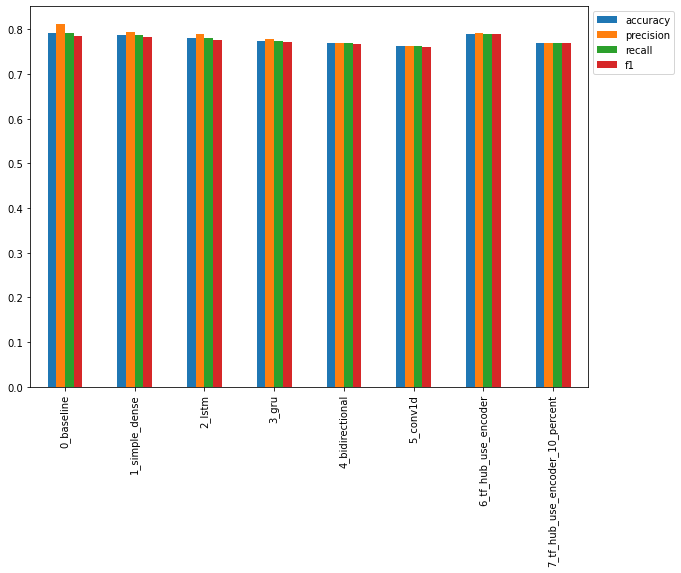

In [135]:
# Plot and compare all of the model results
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

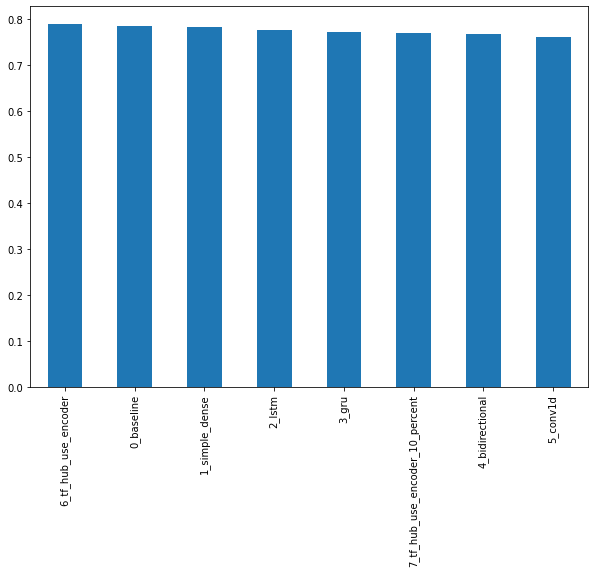

In [136]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

## Uploading our model training logs to TensorBoard.dev
We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [137]:
# View TensorBoard logs of transfer learning modelling experiments (plus all of our other models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_logs/ \
  --name "NLP Modelling Experiments" \
  --description "Compareing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
  --one_shot # exit the uploaded once uploading is finished

2021-10-29 16:19:29.776987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 16:19:29.799479: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-29 16:19:29.799974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Po

Now I've ran the cell above, my modelling experiments are visible on TensorBoard.dev: https://tensorboard.dev/experiment/C6BcyKuvSKqi2ppQkf09vw/#scalars

> **Resource:** TensorBoard is great for quickly tracking experiments but for larger scale experiments and a whole bunch more tracking options, check out Weights & Biases: https://wandb.ai/site

In [138]:
# # See the previous TensorBoard Dev experiments you've run...
# !tensorboard dev list

In [139]:
# If you need to delete an experiment from TensorBoard, you can run the following:
# !tensorboard dev delete --experiment_id 7SXld3YBTxuGOXw6vjOiXw

## Saving and loading a trained model

There are two main formats to save a model to in TensorFlow:
1. The HDF5 format
2. The `SavedModel` format (this is the default when using TensorFlow)

In [140]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

In [141]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [142]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences,
                        val_labels)

24/24 [==============================] - 1s 17ms/step - loss: 0.4698 - accuracy: 0.7900


[0.46984758973121643, 0.7900262475013733]

In [143]:
model_6_results

{'accuracy': 79.00262467191601,
 'f1': 0.7886741430048517,
 'precision': 0.7909267110841915,
 'recall': 0.7900262467191601}

Now let's save to the `SavedModel` format...(see more on this here: https://www.tensorflow.org/tutorials/keras/save_and_load)

In [144]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [145]:
# Load in a model from the SavedModel format
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [146]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 17ms/step - loss: 0.4698 - accuracy: 0.7900


[0.46984758973121643, 0.7900262475013733]

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong?
* And of these wrong examples which ones is it getting *most* wrong (those with prediction probabilities closes to the opposite class)

For example if a sample should have a label of 0 but our model predicts a prediction probability of 0.999 (really close to 1) and vice versa.

In [147]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2021-10-29 16:20:39--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 64.233.182.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  42.1MB/s    in 8.7s    

2021-10-29 16:20:48 (105 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.ind

In [148]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 18ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [149]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [150]:
model_6_pretrained_pred_probs.shape

(762, 1)

In [151]:
# Create DataFrame with validation sentences, validation labels and best performing model predictions plus probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()



,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [152]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [153]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Let's remind ourselves of the target labels...
* `0` = not disaster
* `1` = disaster

In [154]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.8148158192634583
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

In [156]:
# Check the false negatives (model predicted 0 when should've been 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.055075809359550476
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054597001522779465
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.04963727295398712
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0

## Making predictions on the test dataset

In [161]:
# Making predictions on the test dataset and visualizing them
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

Pred: 0, Prob: 0.15673701465129852
Text:
Do you have an emergency drinking water plan? Download guide in English Spanish French Arabic or Vietnamese. http://t.co/S0ktilisKq

-----

Pred: 0, Prob: 0.12882278859615326
Text:
White Space Devices Pose Threat to Medical Devices Warns Lawmakers  http://t.co/kZ240R8qp9

-----

Pred: 0, Prob: 0.12646973133087158
Text:
I'm so dried out in this desert let me know I wanna be with you speaking of floods speaking of truth - Laleh ????????

-----

Pred: 0, Prob: 0.12842001020908356
Text:
Today we played mini golf in the rain I was called pretty by a creepy old guy and pretended we didn't speak English to get out of trouble

-----

Pred: 1, Prob: 0.8199871778488159
Text:
#USGS M 1.9 - 15km E of Anchorage Alaska: Time2015-08-06 00:11:16 UTC2015-08-05 16:11:16 -08:00 at epicen... http://t.co/HkIiPyX5jL #SM

-----

Pred: 0, Prob: 0.13987064361572266
Text:
#Rick Grimes: 'We'll survive. I'll show you how.'

#TheWalkingDead
Season 5
#Conquer
29 Mar 2015 htt

## Your challenge... predicting on Tweets from the wild

Go to your favourite Twitter account and copy one of their latest Tweets.

Then pass that Tweet through our trianed model.

Is that Tweet a disaster or not disaster (according to the model)? Is the model right or wrong?

@mrdbourke

## The speed/score tradeoff

In [164]:
# Let's make a function to measure the time of prediction
import time

def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time - start_time # calculate how long predictions took to make
  time_per_pred = total_time / len(samples)
  return total_time, time_per_pred

In [165]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)

model_6_total_pred_time, model_6_time_per_pred

(0.3784874329999184, 0.0004967026679788955)

In [166]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.030066932999943674, 3.9457917322760726e-05)

In [167]:
# Get results for pretrained GS model
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'f1': 0.8148082644367335,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651}

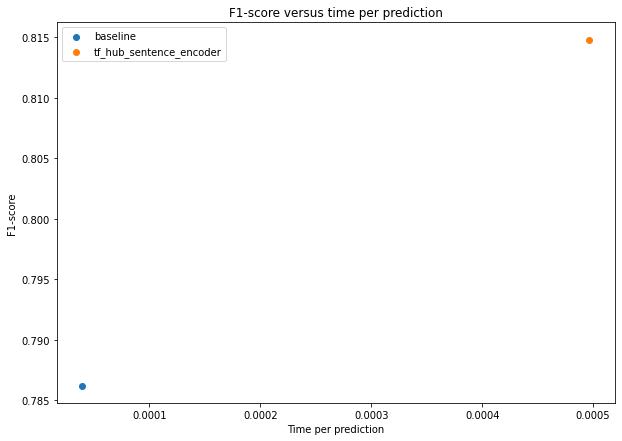

In [169]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");